In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import numpy as np
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, to_rgba
import matplotlib.ticker as mticker
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xesmf as xe

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Input, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow import keras 

from pickle import dump, load

In [2]:
mom6_labels = xr.open_dataset(f'Data_Step2/control/mom6_labels_6_clusters.nc')['Label']
# Ensure that longitude coords are from -180 to 180
mom6_labels.coords['lon'] = (mom6_labels.coords['lon'] + 180) % 360 - 180
mom6_labels = mom6_labels.sortby(mom6_labels.lon)

col_height = xr.open_dataset(f'Data_Step2/control/col_height.nc').rename({'yh':'lat', 'xh':'lon'})['col_height']
# Ensure that longitude coords are from -180 to 180
col_height.coords['lon'] = (col_height.coords['lon'] + 180) % 360 - 180
col_height = col_height.sortby(col_height.lon)

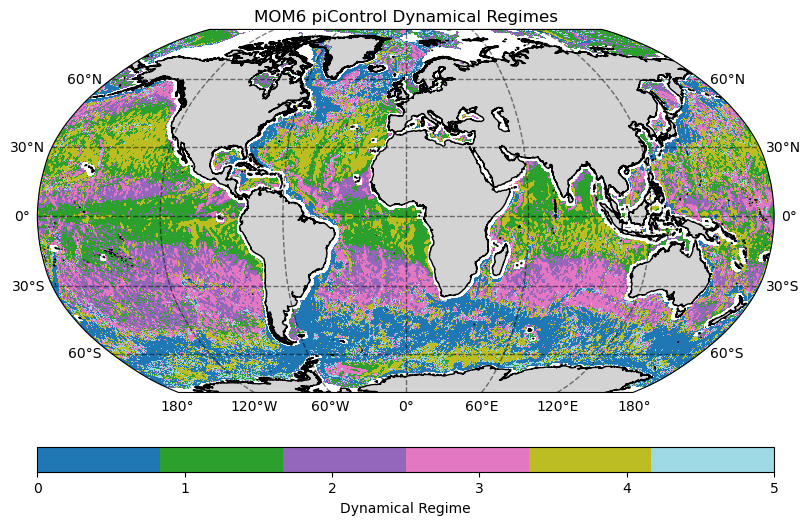

In [3]:
fig, axes = plt.subplots(1, 1, subplot_kw={'projection':ccrs.Robinson()}, figsize=(8,7), constrained_layout=True)
mom6_labels.plot(ax=axes, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('tab20', 6),
                 cbar_kwargs={'label':'Dynamical Regime', 'orientation':'horizontal', 'aspect':30})

axes.add_feature(cfeature.LAND, facecolor='lightgrey')
axes.coastlines(resolution='10m')

gl = axes.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.top_labels = False

axes.set_title('MOM6 piControl Dynamical Regimes')

#plt.savefig('figures/neurips/mom6_labels_piControl.png', transparent=True, dpi=600)
plt.show()

In [7]:
scaler = load(open(f'Data_Step2/control/scaler.pkl', 'rb'))
scaler.mean_, scaler.scale_

(array([-2.85953411e-11,  3.68473248e+03, -2.93517822e-01, -1.78395655e-05,
         7.85527389e-05,  2.14230237e-03,  4.95123948e-07,  6.49555247e-07,
         3.01111445e+08, -1.45646523e+07]),
 array([1.86685043e-10, 1.61048766e+03, 7.99068436e-01, 1.03240757e-04,
        6.63678833e-01, 4.30530589e-02, 1.86624197e-05, 2.45397653e-06,
        1.35950753e+09, 9.36660921e+08]))

In [8]:
experiment = 'historical'
num_clusters = 6

missingdataindex = np.load(f'Data_Step2/{experiment}/missingdataindex.npy')
maskTraining = np.load(f'Data_Step2/{experiment}/maskTraining.npy')
maskVal = np.load(f'Data_Step2/{experiment}/maskVal.npy')
maskTest = np.load(f'Data_Step2/{experiment}/maskTest.npy')

total_features = np.load(f'Data_Step2/{experiment}/total_features.npy')
train_features = np.load(f'Data_Step2/{experiment}/train_features.npy')
val_features = np.load(f'Data_Step2/{experiment}/val_features.npy')
test_features = np.load(f'Data_Step2/{experiment}/test_features.npy')

X_total_scaled = scaler.transform(total_features)
X_train_scaled = scaler.transform(train_features)
X_val_scaled = scaler.transform(val_features)
X_test_scaled = scaler.transform(test_features)

model_name = f'model_24x2_16x2_tanh_{num_clusters}_clusters'
ensemble_size = 50

prob_predictions = np.empty(shape=(ensemble_size, X_total_scaled.shape[0], num_clusters))
for i in range(ensemble_size):
    model = tf.keras.models.load_model(f'saved_models/{model_name}/model_{i}.h5')
    prob_predictions[i] = model(X_total_scaled).numpy()

prob_mean = prob_predictions.mean(axis = 0)

pred = np.nan * np.zeros((1080,1440))
pred[~missingdataindex] = prob_mean.argmax(axis=1)
pred = xr.DataArray(data=pred,
                    dims=['lat','lon'],
                    coords=dict(lat=col_height['lat'], lon=col_height['lon']),
                    name='Model Pred')

pred_probs = np.nan * np.zeros((1080,1440,6))
pred_probs[~missingdataindex] = prob_mean
pred_probs = xr.DataArray(data=pred_probs,
                          dims=['lat','lon','regime'],
                          coords=dict(lat=col_height['lat'], lon=col_height['lon'], regime=list(range(6))),
                          name='Prediction probabilities')

prob_predictions_swapped = np.swapaxes(prob_predictions, 0, 1)
pred_full = np.nan * np.zeros((1080,1440,ensemble_size,num_clusters))
pred_full[~missingdataindex] = prob_predictions_swapped
pred_full = xr.DataArray(data=pred_full,
                         dims=['lat','lon','member', 'label'],
                         coords=dict(lat=col_height['lat'], lon=col_height['lon'],
                                     member=list(range(ensemble_size)), label=list(range(num_clusters))),
                         name='Predictions')

entropy_vals = -np.sum(prob_mean*np.log2(prob_mean), axis=1)
entropy = np.nan * np.zeros((1080,1440))
entropy[~missingdataindex] = entropy_vals
entropy = xr.DataArray(data=entropy,
                       dims=['lat','lon'],
                       coords=dict(lat=col_height['lat'], lon=col_height['lon']),
                       name='Entropy')

experiment_one = experiment
pred_one = pred
pred_probs_one = pred_probs
pred_full_one = pred_full
entropy_one = entropy

In [9]:
experiment = 'ssp585_2080_2099'
num_clusters = 6

missingdataindex = np.load(f'Data_Step2/{experiment}/missingdataindex.npy')
maskTraining = np.load(f'Data_Step2/{experiment}/maskTraining.npy')
maskVal = np.load(f'Data_Step2/{experiment}/maskVal.npy')
maskTest = np.load(f'Data_Step2/{experiment}/maskTest.npy')

total_features = np.load(f'Data_Step2/{experiment}/total_features.npy')
train_features = np.load(f'Data_Step2/{experiment}/train_features.npy')
val_features = np.load(f'Data_Step2/{experiment}/val_features.npy')
test_features = np.load(f'Data_Step2/{experiment}/test_features.npy')

X_total_scaled = scaler.transform(total_features)
X_train_scaled = scaler.transform(train_features)
X_val_scaled = scaler.transform(val_features)
X_test_scaled = scaler.transform(test_features)

model_name = f'model_24x2_16x2_tanh_{num_clusters}_clusters'
ensemble_size = 50

prob_predictions = np.empty(shape=(ensemble_size, X_total_scaled.shape[0], num_clusters))
for i in range(ensemble_size):
    model = tf.keras.models.load_model(f'saved_models/{model_name}/model_{i}.h5')
    prob_predictions[i] = model(X_total_scaled).numpy()

prob_mean = prob_predictions.mean(axis = 0)

pred = np.nan * np.zeros((1080,1440))
pred[~missingdataindex] = prob_mean.argmax(axis=1)
pred = xr.DataArray(data=pred,
                    dims=['lat','lon'],
                    coords=dict(lat=col_height['lat'], lon=col_height['lon']),
                    name='Model Pred')

pred_probs = np.nan * np.zeros((1080,1440,6))
pred_probs[~missingdataindex] = prob_mean
pred_probs = xr.DataArray(data=pred_probs,
                          dims=['lat','lon','regime'],
                          coords=dict(lat=col_height['lat'], lon=col_height['lon'], regime=list(range(6))),
                          name='Prediction probabilities')

prob_predictions_swapped = np.swapaxes(prob_predictions, 0, 1)
pred_full = np.nan * np.zeros((1080,1440,ensemble_size,num_clusters))
pred_full[~missingdataindex] = prob_predictions_swapped
pred_full = xr.DataArray(data=pred_full,
                         dims=['lat','lon','member', 'label'],
                         coords=dict(lat=col_height['lat'], lon=col_height['lon'],
                                     member=list(range(ensemble_size)), label=list(range(num_clusters))),
                         name='Predictions')

entropy_vals = -np.sum(prob_mean* np.log2(prob_mean), axis=1)
entropy = np.nan * np.zeros((1080,1440))
entropy[~missingdataindex] = entropy_vals
entropy = xr.DataArray(data=entropy,
                       dims=['lat','lon'],
                       coords=dict(lat=col_height['lat'], lon=col_height['lon']),
                       name='Entropy')

experiment_two = experiment
pred_two = pred
pred_probs_two = pred_probs
pred_full_two = pred_full
entropy_two = entropy

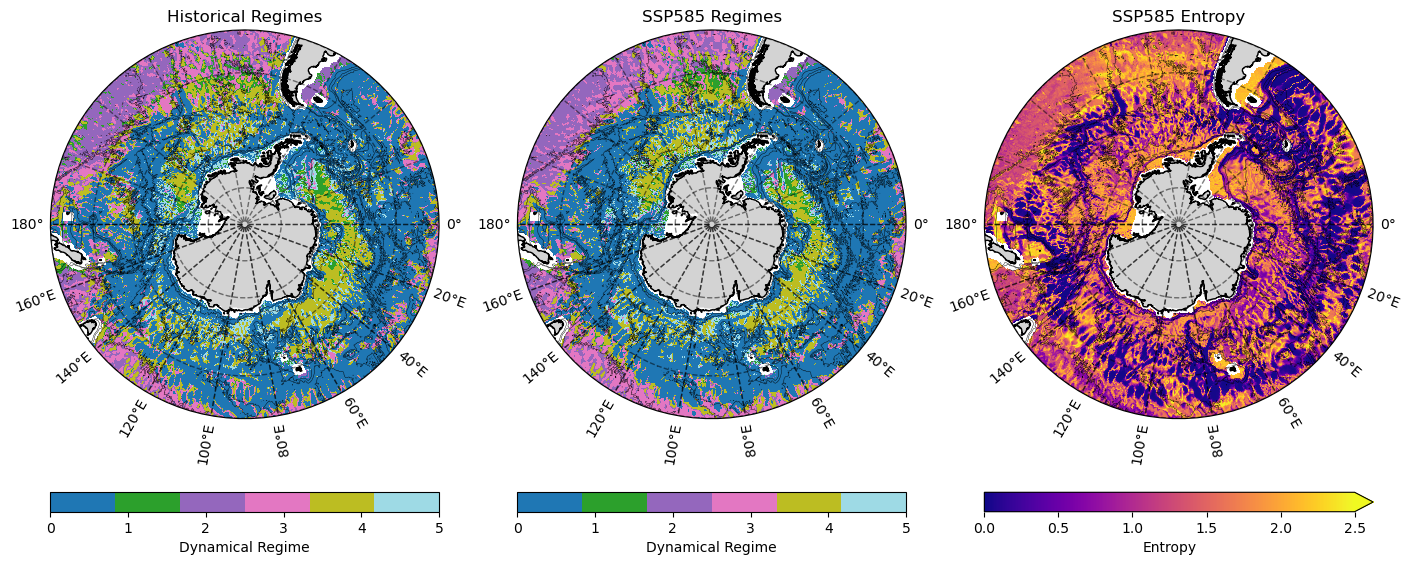

In [7]:
fig, axes = plt.subplots(1, 3, subplot_kw={'projection':ccrs.SouthPolarStereo(central_longitude=-90)}, figsize=(14,6), constrained_layout=True)

pred_one.sel(lat=slice(-90,-40)).plot(ax=axes[0], transform=ccrs.PlateCarree(),
                                      cmap=plt.get_cmap('tab20', num_clusters),
                                      cbar_kwargs={'label':'Dynamical Regime',
                                                   'orientation':'horizontal',
                                                   'aspect':20})

pred_two.sel(lat=slice(-90,-40)).plot(ax=axes[1], transform=ccrs.PlateCarree(),
                                      cmap=plt.get_cmap('tab20', num_clusters),
                                      cbar_kwargs={'label':'Dynamical Regime',
                                                   'orientation':'horizontal',
                                                   'aspect':20})

entropy_two.sel(lat=slice(-90,-40)).plot(ax=axes[2], transform=ccrs.PlateCarree(),
                                         cmap='plasma', vmin=0, vmax=2.5,
                                         cbar_kwargs={'label':'Entropy',
                                                      'orientation':'horizontal',
                                                      'aspect':20})

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

titles = ['Historical Regimes', 'SSP585 Regimes', 'SSP585 Entropy']

for i in range(3):
    axes[i].add_feature(cfeature.LAND, facecolor='lightgrey')
    axes[i].coastlines(resolution='10m')
    axes[i].set_boundary(circle, transform=axes[i].transAxes)
    xr.plot.contour(col_height.sel(lat=slice(-90,-40)), ax=axes[i],
                    transform=ccrs.PlateCarree(), colors='black', linewidths=0.3)
    
    gl = axes[i].gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xlocator = mticker.FixedLocator(np.arange(0,181,20))
    gl.ylocator = mticker.FixedLocator([])
    gl = axes[i].gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=False)
    gl.xlocator = mticker.FixedLocator(np.arange(-180,181,20))
    
for i in range(3):
    axes[i].set_title(titles[i])
    
#plt.savefig('figures/neurips/nn_historical_and_ssp585.png', transparent=True, dpi=600)
plt.show()

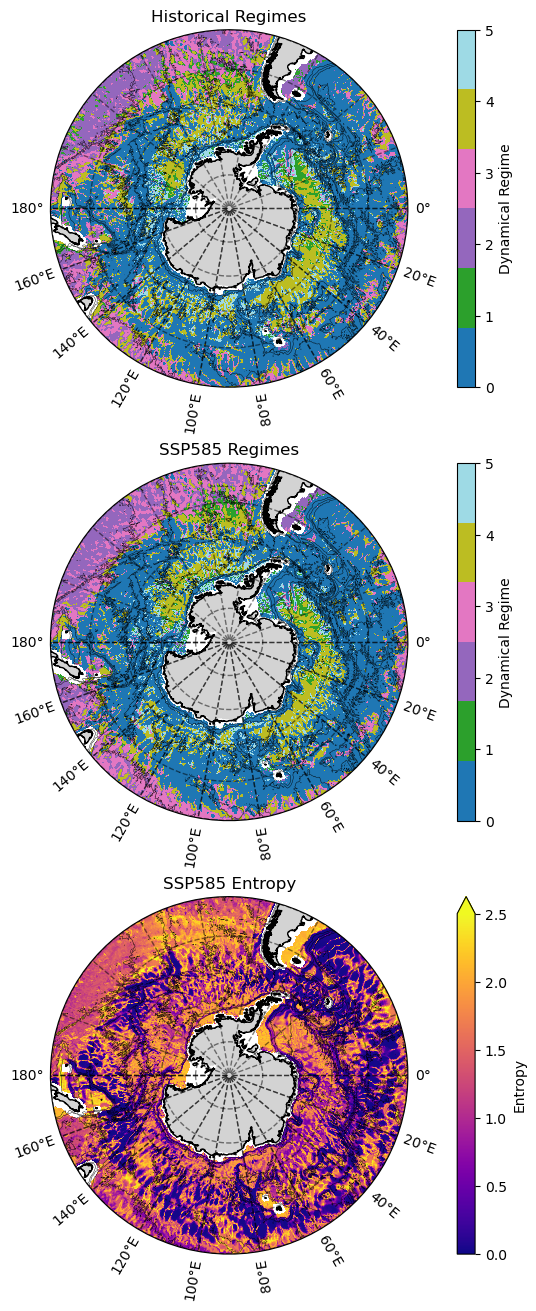

In [8]:
fig, axes = plt.subplots(3, 1, subplot_kw={'projection':ccrs.SouthPolarStereo(central_longitude=-90)}, figsize=(5.25,13), constrained_layout=True)

pred_one.sel(lat=slice(-90,-40)).plot(ax=axes[0], transform=ccrs.PlateCarree(),
                                      cmap=plt.get_cmap('tab20', num_clusters),
                                      cbar_kwargs={'label':'Dynamical Regime',
                                                   'orientation':'vertical',
                                                   'aspect':20})

pred_two.sel(lat=slice(-90,-40)).plot(ax=axes[1], transform=ccrs.PlateCarree(),
                                      cmap=plt.get_cmap('tab20', num_clusters),
                                      cbar_kwargs={'label':'Dynamical Regime',
                                                   'orientation':'vertical',
                                                   'aspect':20})

entropy_two.sel(lat=slice(-90,-40)).plot(ax=axes[2], transform=ccrs.PlateCarree(),
                                         cmap='plasma', vmin=0, vmax=2.5,
                                         cbar_kwargs={'label':'Entropy',
                                                      'orientation':'vertical',
                                                      'aspect':20})

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

titles = ['Historical Regimes', 'SSP585 Regimes', 'SSP585 Entropy']

for i in range(3):
    axes[i].add_feature(cfeature.LAND, facecolor='lightgrey')
    axes[i].coastlines(resolution='10m')
    axes[i].set_boundary(circle, transform=axes[i].transAxes)
    xr.plot.contour(col_height.sel(lat=slice(-90,-40)), ax=axes[i],
                    transform=ccrs.PlateCarree(), colors='black', linewidths=0.3)
    
    gl = axes[i].gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xlocator = mticker.FixedLocator(np.arange(0,181,20))
    gl.ylocator = mticker.FixedLocator([])
    gl = axes[i].gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=False)
    gl.xlocator = mticker.FixedLocator(np.arange(-180,181,20))
    
for i in range(3):
    axes[i].set_title(titles[i])
    
plt.savefig('figures/neurips/nn_historical_and_ssp585_vertical.png', transparent=False, dpi=600)
plt.show()

In [10]:
umo_1 = xr.open_mfdataset('Data_Step2/historical/umo.nc')['umo'].rename({'yh':'lat', 'xq':'lon', 'z_l':'depth'})
umo_2 = xr.open_mfdataset('Data_Step2/ssp585_2080_2099/umo.nc')['umo'].rename({'yh':'lat', 'xq':'lon', 'z_l':'depth'})

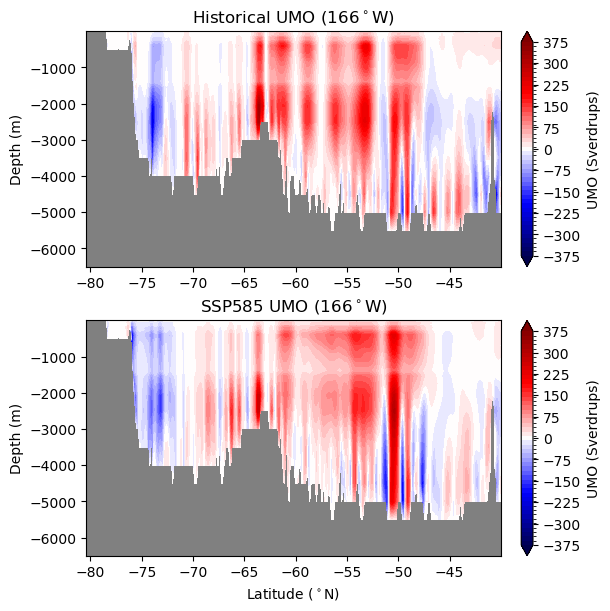

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(6,6), constrained_layout=True)
ticks = np.arange(-375,376,75)

# Convert to Sverdrups
to_plot = umo_1.sel(lat=slice(-90,-40)).sel(lon=-166, method='nearest') / 1e6
# Invert depth coordinate
to_plot['depth'] = -to_plot['depth']
xr.plot.contourf(to_plot, ax=axes[0], cmap=plt.cm.seismic, extend='both', levels=50,
                 vmin=-375, vmax=375, cbar_kwargs={'label':'UMO (Sverdrups)', 'ticks':ticks})

# Convert to Sverdrups
to_plot = umo_2.sel(lat=slice(-90,-40)).sel(lon=-166, method='nearest') / 1e6
# Invert depth coordinate
to_plot['depth'] = -to_plot['depth']
xr.plot.contourf(to_plot, ax=axes[1], cmap=plt.cm.seismic, extend='both', levels=50,
                 vmin=-375, vmax=375, cbar_kwargs={'label':'UMO (Sverdrups)', 'ticks':ticks})

for i in range(2):
    axes[i].set_facecolor('Grey')
    axes[i].set_xlabel('Latitude ($^\circ$N)')
    axes[i].set_ylabel('Depth (m)')

axes[0].set_title(r'Historical UMO ($166^\circ$W)')
axes[1].set_title(r'SSP585 UMO ($166^\circ$W)')

axes[0].set_xlabel('')

#plt.savefig('figures/neurips/umo_transects_historical_and_ssp585_vertical.png', transparent=False, dpi=600)
plt.show()

In [12]:
curlTau_one = xr.open_dataset(f'Data_Step2/{experiment_one}/curlTau.nc')['Curl_taus'].rename({'yq':'lat', 'xq':'lon'})
curlTau_two = xr.open_dataset(f'Data_Step2/{experiment_two}/curlTau.nc')['Curl_taus'].rename({'yq':'lat', 'xq':'lon'})

curlTau_bias = curlTau_two - curlTau_one

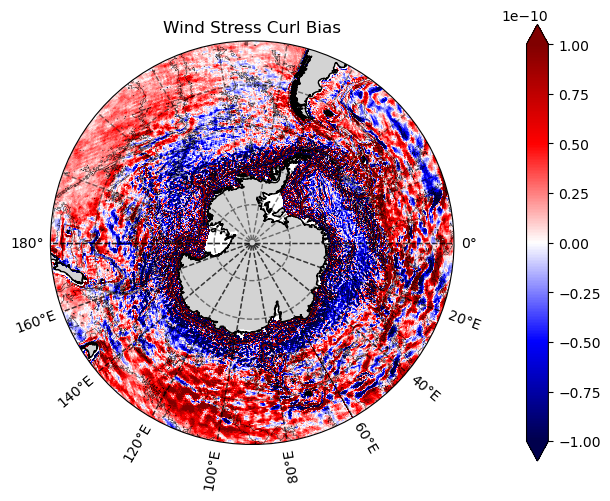

In [12]:
fig, axes = plt.subplots(1, 1, subplot_kw={'projection':ccrs.SouthPolarStereo(central_longitude=-90)}, figsize=(6,5), constrained_layout=True)

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

to_plot = curlTau_bias.sel(lat=slice(-90,-40))

to_plot.plot(ax=axes, transform=ccrs.PlateCarree(), vmin=-1e-10, vmax=1e-10, cmap='seismic', cbar_kwargs={'label':''})

xr.plot.contour(col_height.sel(lat=slice(-90,-40)), ax=axes,
                transform=ccrs.PlateCarree(), colors='black', linewidths=0.3)

gl = axes.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.xlocator = mticker.FixedLocator(np.arange(0,181,20))
gl.ylocator = mticker.FixedLocator([])
gl = axes.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=False)
gl.xlocator = mticker.FixedLocator(np.arange(-180,181,20))

axes.add_feature(cfeature.LAND, facecolor='lightgrey')
axes.coastlines(resolution='10m')
axes.set_boundary(circle, transform=axes.transAxes)
axes.set_title('Wind Stress Curl Bias')
    
#plt.savefig('figures/neurips/wind_stress_curl_bias.png', transparent=False, dpi=600)
plt.show()

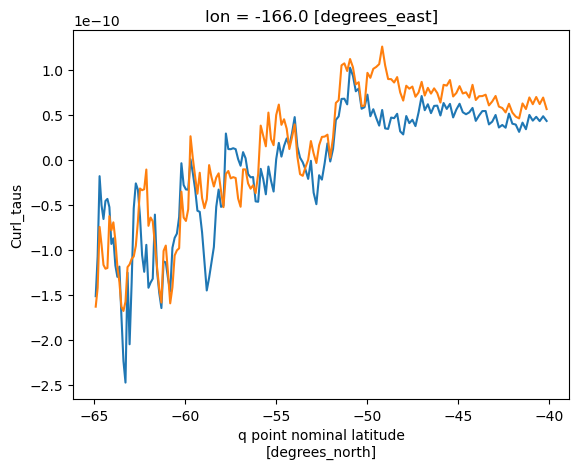

In [13]:
curlTau_one.sel(lat=slice(-65,-40)).sel(lon=-166, method='nearest').plot()
curlTau_two.sel(lat=slice(-65,-40)).sel(lon=-166, method='nearest').plot()

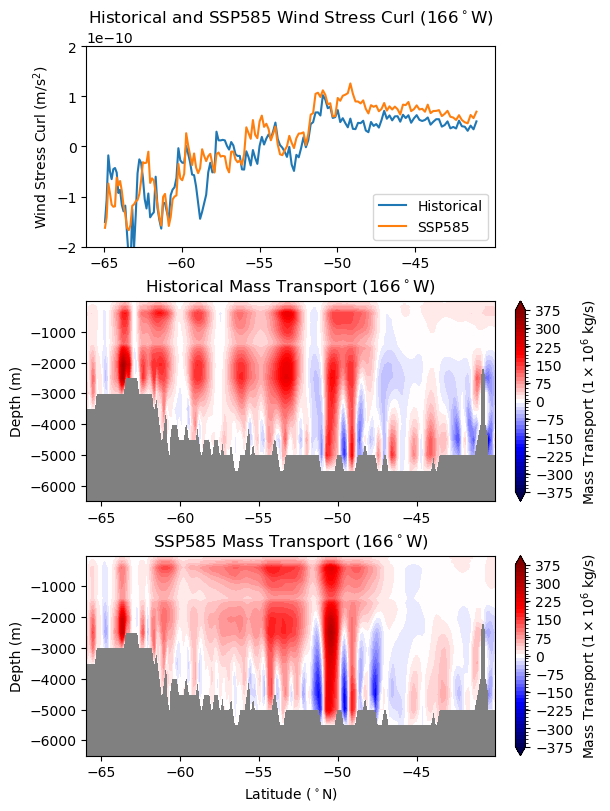

In [17]:
fig, axes = plt.subplots(3, 1, figsize=(6,8), constrained_layout=True)
ticks = np.arange(-375,376,75)

curlTau_one.sel(lat=slice(-65,-41)).sel(lon=-166, method='nearest').plot(ax=axes[0], label='Historical')
curlTau_two.sel(lat=slice(-65,-41)).sel(lon=-166, method='nearest').plot(ax=axes[0], label='SSP585')

# Convert to Sverdrups
to_plot = umo_1.sel(lat=slice(-66,-40)).sel(lon=-166, method='nearest') / 1e6
# Invert depth coordinate
to_plot['depth'] = -to_plot['depth']
xr.plot.contourf(to_plot, ax=axes[1], cmap=plt.cm.seismic, extend='both', levels=50,
                 vmin=-375, vmax=375, cbar_kwargs={'label':r'Mass Transport ($1 \times 10^6$ kg/s)', 'ticks':ticks})

# Convert to Sverdrups
to_plot = umo_2.sel(lat=slice(-66,-40)).sel(lon=-166, method='nearest') / 1e6
# Invert depth coordinate
to_plot['depth'] = -to_plot['depth']
xr.plot.contourf(to_plot, ax=axes[2], cmap=plt.cm.seismic, extend='both', levels=50,
                 vmin=-375, vmax=375, cbar_kwargs={'label':r'Mass Transport ($1 \times 10^6$ kg/s)', 'ticks':ticks})

for i in range(1,3):
    axes[i].set_facecolor('Grey')
    axes[i].set_xlabel('Latitude ($^\circ$N)')
    axes[i].set_ylabel('Depth (m)')

axes[1].set_title(r'Historical Mass Transport ($166^\circ$W)')
axes[2].set_title(r'SSP585 Mass Transport ($166^\circ$W)')

axes[1].set_xlabel('')

axes[0].set_ylim(-2e-10,2e-10)
axes[0].set_ylabel(r'Wind Stress Curl (m/s$^2$)')
axes[0].set_xlabel('')
axes[0].set_title(r'Historical and SSP585 Wind Stress Curl ($166^\circ$W)')
axes[0].legend(loc='lower right')

axes[0].set_xticks([-65,-60,-55,-50,-45])

#plt.savefig('figures/neurips/umo_transects_with_wind_stress_vertical.png', transparent=False, dpi=600)
plt.show()

In [3]:
train_val_test = mom6_labels
# Test area
train_val_test = xr.where((train_val_test.lon >= -78.78) & (train_val_test.lon <= 21.11) & (~np.isnan(train_val_test)), 2, train_val_test)
# Validation area
train_val_test = xr.where((train_val_test.lon >= -129.6) & (train_val_test.lon < -78.78) & (~np.isnan(train_val_test)), 1, train_val_test)
# The rest is training area
train_val_test = xr.where((train_val_test.lon >= -180) & (train_val_test.lon <= -129.8) & (~np.isnan(train_val_test)), 0, train_val_test)
train_val_test = xr.where((train_val_test.lon >= 21.25) & (train_val_test.lon <= 180) & (~np.isnan(train_val_test)), 0, train_val_test)

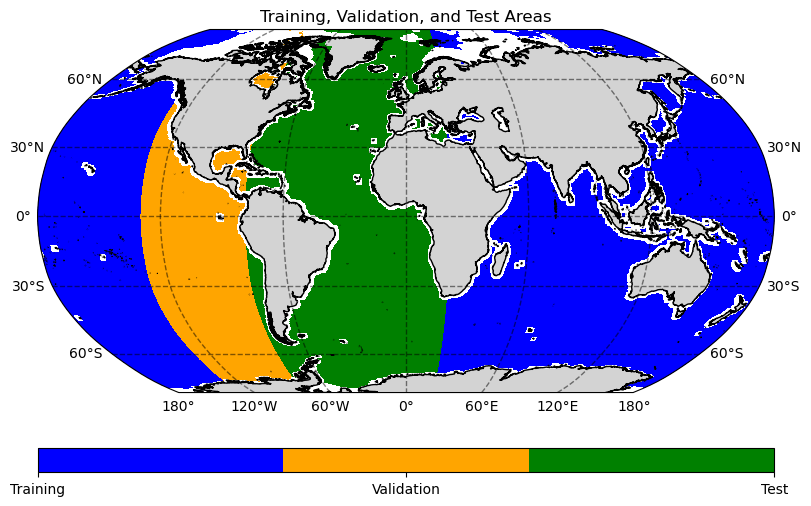

In [5]:
fig, axes = plt.subplots(1, 1, subplot_kw={'projection':ccrs.Robinson()}, figsize=(8,7), constrained_layout=True)
cmap = ListedColormap(['blue', 'orange', 'green'])
pcm = train_val_test.transpose().plot(ax=axes, transform=ccrs.PlateCarree(), vmin=0, vmax=2, cmap=cmap, add_colorbar=False)

cbar = fig.colorbar(pcm, ax=axes, orientation='horizontal', label='', ticks=[0,1,2], aspect=30)
cbar.ax.set_xticklabels(['Training', 'Validation', 'Test'])

axes.add_feature(cfeature.LAND, facecolor='lightgrey')
axes.coastlines(resolution='10m')

gl = axes.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.top_labels = False

axes.set_title('Training, Validation, and Test Areas')

plt.savefig('figures/neurips/train_val_test_areas.png', transparent=False, dpi=600)
plt.show()